# (Teoria)Transformar dados com o Spark

## Modificar e salvar dataframes

O Apache Spark fornece o objeto dataframe como a estrutura primária para trabalhar com dados. Você pode usar dataframes para consultar e transformar dados e persistir os resultados em um data lake. Para carregar dados em um dataframe, use a função spark.read , especificando o formato do arquivo, o caminho e, opcionalmente, o esquema dos dados a serem lidos. Por exemplo, o código a seguir carrega dados de todos os arquivos .csv na pasta pedidos em um dataframe chamado order_details e, em seguida, exibe os cinco primeiros registros.

In [ ]:
order_details = spark.read.csv('/orders/*.csv', header=True, inferSchema=True)
display(order_details.limit(5))

## Transformar a estrutura de dados

Depois de carregar os dados de origem em um dataframe, você pode usar os métodos do objeto dataframe e as funções do Spark para transformá-los. As operações típicas em um dataframe incluem:

Filtrando linhas e colunas

Renomeando colunas

Criando novas colunas, muitas vezes derivadas das existentes

Substituindo valores nulos ou outros

No exemplo a seguir, o código usa a split função para separar os valores na coluna CustomerName em duas novas colunas chamadas FirstName e LastName. Em seguida, ele usa o drop método para excluir a coluna CustomerName original.

In [ ]:
from pyspark.sql.functions import split, col

# Create the new FirstName and LastName fields
transformed_df = order_details.withColumn("FirstName", split(col("CustomerName"), " ").getItem(0)).withColumn("LastName", split(col("CustomerName"), " ").getItem(1))

# Remove the CustomerName field
transformed_df = transformed_df.drop("CustomerName")

display(transformed_df.limit(5))

## Salvar os dados transformados

Depois que o dataFrame estiver na estrutura necessária, você poderá salvar os resultados em um formato com suporte no data lake.

O exemplo de código a seguir salva o dataFrame em um arquivo parquet no data lake, substituindo qualquer arquivo existente com o mesmo nome.

In [ ]:
transformed_df.write.mode("overwrite").parquet('/transformed_data/orders.parquet')
print ("Transformed data saved!")

## Arquivos de dados de partição

O particionamento é uma técnica de otimização que permite ao Spark maximizar o desempenho entre os nós de trabalho. Mais ganhos de desempenho podem ser obtidos ao filtrar dados em consultas eliminando a E/S de disco desnecessária.

Para salvar um dataframe como um conjunto particionado de arquivos, use o método partitionBy ao gravar os dados.

O exemplo a seguir cria um campo Ano derivado. Em seguida, usa-os para particionar os dados.

In [ ]:
from pyspark.sql.functions import year, col

# Load source data
df = spark.read.csv('/orders/*.csv', header=True, inferSchema=True)

# Add Year column
dated_df = df.withColumn("Year", year(col("OrderDate")))

# Partition by year
dated_df.write.partitionBy("Year").mode("overwrite").parquet("/data")

Os nomes de pasta gerados ao particionar um dataframe incluem o nome e o valor da coluna de particionamento em um formato column=value

## Filtrar arquivos parquet em uma consulta

Ao ler dados de arquivos parquet em um dataframe, você tem a capacidade de efetuar pull de dados de qualquer pasta dentro das pastas hierárquicas. Esse processo de filtragem é feito com o uso de valores explícitos e curingas nos campos particionados.

No exemplo a seguir, o código a seguir efetuará pull dos pedidos de vendas, que foram feitos em 2020.

In [ ]:
orders_2020 = spark.read.parquet('/partitioned_data/Year=2020')
display(orders_2020.limit(5))

## Transformar dados com o SQL

O exemplo de código a seguir salva um dataframe (carregado de arquivos CSV) como um nome de tabela externo sales_orders. Os arquivos são armazenados na pasta /sales_orders_table no data lake.

In [ ]:
order_details.write.saveAsTable('sales_orders', format='parquet', mode='overwrite', path='/sales_orders_table')

Depois de definir uma tabela, você poderá usar o SQL para consultar e transformar os dados. O código a seguir cria duas novas colunas derivadas denominadas Ano e Mês e cria uma nova tabela transformed_orders com as novas colunas derivadas adicionadas.

In [ ]:
# Create derived columns
sql_transform = spark.sql("SELECT *, YEAR(OrderDate) AS Year, MONTH(OrderDate) AS Month FROM sales_orders")

# Save the results
sql_transform.write.partitionBy("Year","Month").saveAsTable('transformed_orders', format='parquet', mode='overwrite', path='/transformed_orders_table')

Os arquivos de dados da nova tabela são armazenados em uma hierarquia de pastas com o formato Year=*NNNN* / Month=*N*, com cada pasta contendo um arquivo Parquet para os pedidos correspondentes por ano e mês.

# (Lab Pratico)Transformar dados com o Spark

In [ ]:
 rm -r dp-203 -f
 git clone https://github.com/MicrosoftLearning/dp-203-azure-data-engineer dp-203

In [ ]:
 cd dp-203/Allfiles/labs/06
 ./setup.ps1

Selecione seu espaço de trabalho Synapse e, na página Visão geral, no cartão Abrir Synapse Studio, selecione Abrir para abrir o Synapse Studio em uma nova guia do navegador

Em seguida, baixe o Spark Transform.ipynb em Allfiles/labs/06/notebooks(https://github.com/MicrosoftLearning/dp-203-azure-data-engineer/tree/master/Allfiles/labs/06/notebooks)

Em seguida, na página Desenvolver, expanda Notebooks e clique em + Opções de importação

Selecione o arquivo que você acabou de baixar e salvou como Spark Transfrom.ipynb.

resultado(Print do meu Synapse Studio):

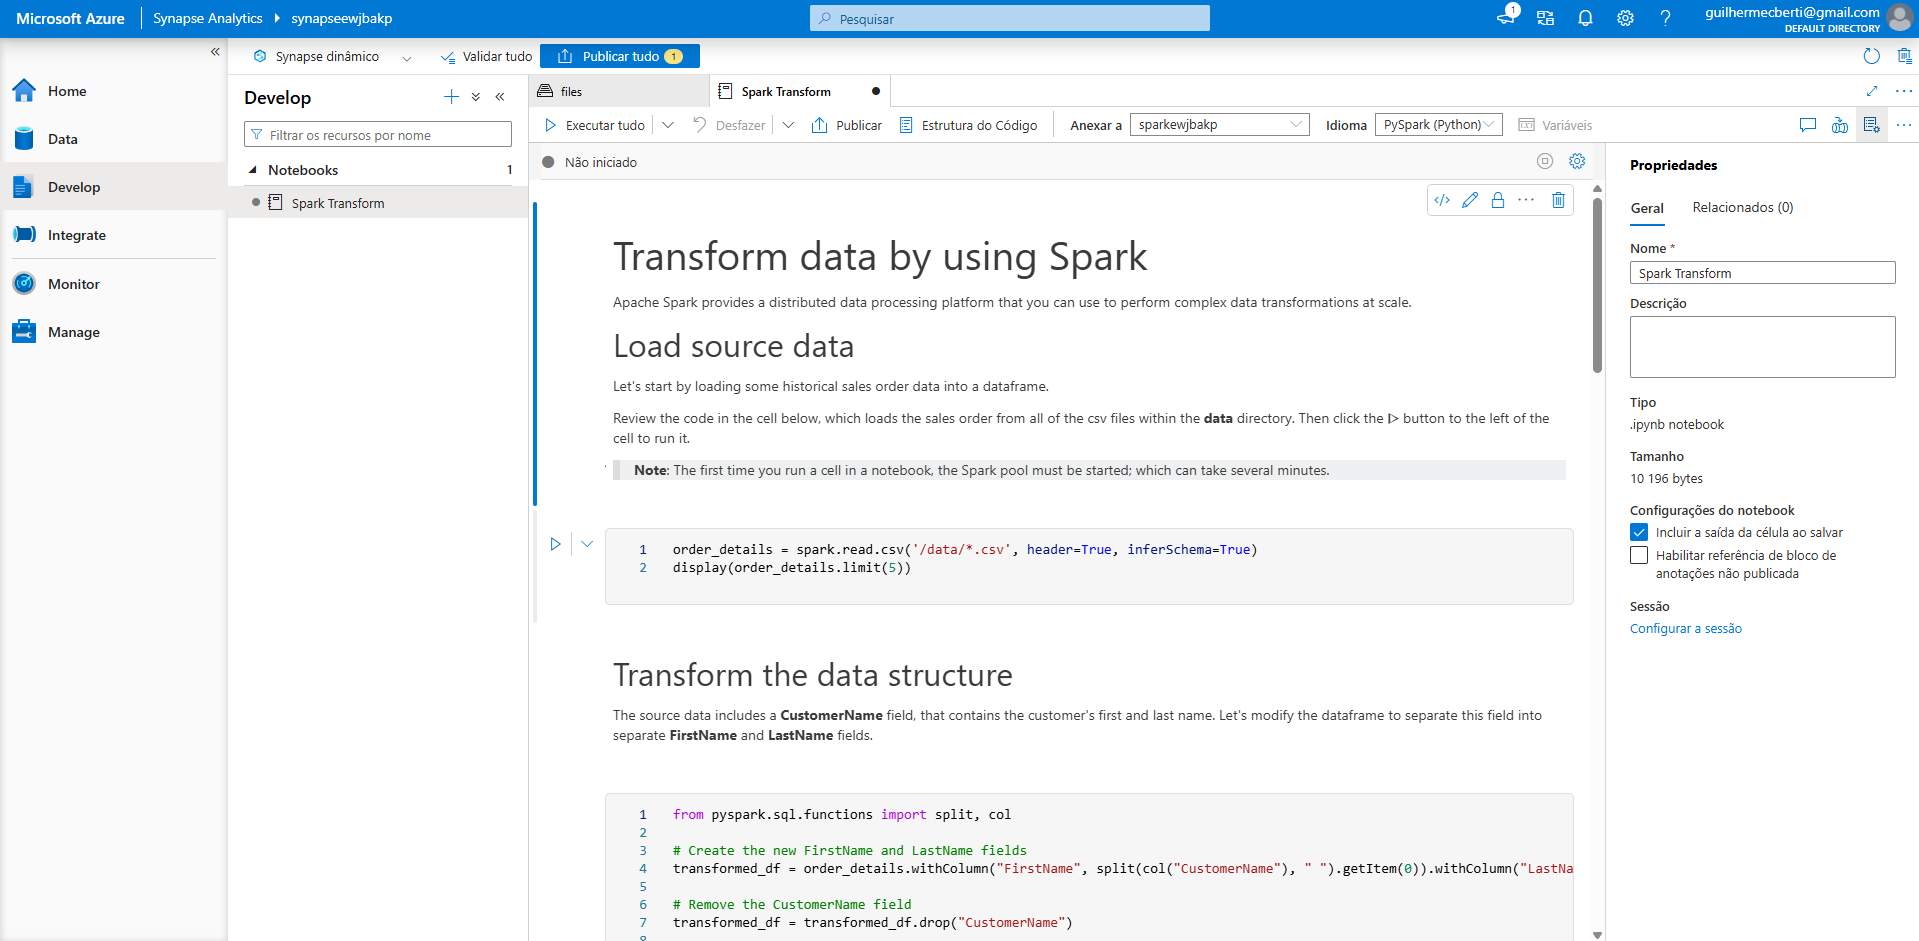

códigos:

In [ ]:
order_details = spark.read.csv('/data/*.csv', header=True, inferSchema=True)
display(order_details.limit(5))

In [ ]:
from pyspark.sql.functions import split, col

# Create the new FirstName and LastName fields
transformed_df = order_details.withColumn("FirstName", split(col("CustomerName"), " ").getItem(0)).withColumn("LastName", split(col("CustomerName"), " ").getItem(1))

# Remove the CustomerName field
transformed_df = transformed_df.drop("CustomerName")

display(transformed_df.limit(5))

In [ ]:
transformed_df.write.mode("overwrite").parquet('/transformed_data/orders.parquet')
print ("Transformed data saved!")

In [ ]:
from pyspark.sql.functions import year, month, col

dated_df = transformed_df.withColumn("Year", year(col("OrderDate"))).withColumn("Month", month(col("OrderDate")))
display(dated_df.limit(5))
dated_df.write.partitionBy("Year","Month").mode("overwrite").parquet("/partitioned_data")
print ("Transformed data saved!")

In [ ]:
orders_2020 = spark.read.parquet('/partitioned_data/Year=2020/Month=*')
display(orders_2020.limit(5))

In [ ]:
order_details.write.saveAsTable('sales_orders', format='parquet', mode='overwrite', path='/sales_orders_table')

In [ ]:
sql_transform = spark.sql("SELECT *, YEAR(OrderDate) AS Year, MONTH(OrderDate) AS Month FROM sales_orders")
display(sql_transform.limit(5))
sql_transform.write.partitionBy("Year","Month").saveAsTable('transformed_orders', format='parquet', mode='overwrite', path='/transformed_orders_table')

In [ ]:
%%sql

SELECT * FROM transformed_orders
WHERE Year = 2021
    AND Month = 1

In [ ]:
%%sql

DROP TABLE transformed_orders;
DROP TABLE sales_orders;